### Group C
### Alex, Andy, Dylan, Jeff, Logan


#### This notebook contains models trained on dataset 1: 
#### Lasso, KNN, Random Forest, SVM
#### Two ensemble methods, Ensemble A is tested on dataset 2 in another notebook.

#### We used k fold cross validation and feature selected genes in each fold based on correlation and ttest. Our models classify AML vs non-AML. The class label AML == 1, non-AML == 0, is decided from the 'Disease' column of the info matrix.

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(version = "3.14",c("GEOquery","e1071", "class", "glmnet","randomForest"))

Bioconductor version '3.14' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Warning message:
“unable to access index for repository https://bioconductor.org/packages/3.14/bioc/src/contrib:
  cannot open URL 'https://bioconductor.org/packages/3.14/bioc/src/contrib/PACKAGES'”
Warning message:
“unable to access index for repository https://bioconductor.org/packages/3.14/data/annotation/src/contrib:
  cannot open URL 'https://bioconductor.org/packages/3.14/data/annotation/src/contrib/PACKAGES'”


In [1]:
install.packages(c("e1071", "class", "glmnet","randomForest"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
load ("AML_datasets.RData")
rm (data.2, data.3, info.2, info.3)

In [4]:
# library(GEOquery)
library(e1071) #svm
library(randomForest)
library(glmnet) #lasso
library(class) #knn

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: Matrix

Loaded glmnet 4.1-6



In [5]:
dim(data.1)
data.1[1:3,1:2]

[1] 12708  2500

,AHW_ALL_BA_025919_13_A_PZ.CEL,AHW_ALL_BA_032751_71_A_PZ.CEL
PAX8,9.221573,8.524435
CCL5,7.990144,6.648112
MMP14,8.391732,8.183514


In [6]:
# k fold indexes
set.seed(234)
data.inds <- 1:2500
shuffled.inds <- sample(data.inds)
fold1.ind <- shuffled.inds[1:500]
fold2.ind <- shuffled.inds[501:1000]
fold3.ind <- shuffled.inds[1001:1500]
fold4.ind <- shuffled.inds[1501:2000]
fold5.ind <- shuffled.inds[2001:2500]

### Please run a fold as needed for your model

In [7]:
#Fold 1
my.data1 <- cbind(data.1[,-fold1.ind],data.1[,fold1.ind])
my.info1 <- rbind(info.1[-fold1.ind,],info.1[fold1.ind,])
aml.prognosis1 <- rep(0, length(my.info1$Disease))
aml.prognosis1[which (my.info1$Disease == "AML")] <- 1
    #Fold 1 Correlation Feature Selection
cor.vec.f1 <- apply (my.data1[,1:2000], 1, function (x){cor(x, aml.prognosis1[1:2000])})
#hist (cor.vec.f1)
cor.ind.f1 <- c(which(cor.vec.f1 > 0.4), which(cor.vec.f1 < -0.4))
cor.ind2.f1 <- c(which(cor.vec.f1 > 0.65), which(cor.vec.f1 < -0.6))

    #Fold 1 Ttest Feature Selection
zero.ind.f1 <- which(aml.prognosis1[1:2000] == 0)
one.ind.f1 <- which(aml.prognosis1[1:2000] == 1)
ttest.vec.f1 <- apply (my.data1, 1, function (x){(t.test(x[one.ind.f1] , x[zero.ind.f1]))$p.value})
gene.ind2.fold1 <- order (ttest.vec.f1)[1:100]

#### Looking at some gene selections from fold 1

In [8]:
#top 37 pvalue genes
top37.ind.f1.cor <- order (ttest.vec.f1)[1:37]
#top 100 ttest genes of fold1
top100.ind.f1.tt <- gene.ind2.fold1
gene.signature.fold1 <- row.names(my.data1[top100.ind.f1.tt,])
gene.signature.fold1[1:15]
#write.table(gene.signature.fold1,file='fold1.100.ttest.csv', row.names=FALSE, col.names=FALSE)

#cor.ind2.f1 <- c(which(cor.vec.f1 > 0.65), which(cor.vec.f1 < -0.6)) # 37 genes
length(which(cor.vec.f1 > 0.65)) # 23 genes
row.names(my.data1[which(cor.vec.f1 > 0.65),])
length(which(cor.vec.f1 < -0.6)) # 14 genes
row.names(my.data1[which(cor.vec.f1 < -0.6),])

# find correlation indexes balanced + / - correlation, with length close to 100
length(which(cor.vec.f1 > 0.61)) # 47 genes
length(which(cor.vec.f1 < -0.53)) # 49 genes
top96.ind.cor.f1 <- c(which(cor.vec.f1 > 0.61), which(cor.vec.f1 < -0.53)) #96 genes

[1] "CREG1"    "ERLIN1"   "CD79A"    "POU2AF1"  "LEF1"     "PAX5"    
 [7] "CFD"      "FAM46A"   "ATP8B4"   "PLAGL1"   "CD22"     "TCL1A"   
[13] "SERPINB1" "QSOX1"    "CD19"

[1] 23

[1] "CTSA"     "ACTA2"    "CREG1"    "QSOX1"    "ERLIN1"   "FAH"     
 [7] "LTBR"     "CEBPA"    "HOMER3"   "KIT"      "CFD"      "TMED9"   
[13] "RNASE2"   "IL18"     "TFEC"     "PLAGL1"   "FUT4"     "SPART"   
[19] "SERPINB1" "AZU1"     "IGF2BP2"  "ATP8B4"   "FAM46A"

[1] 14

[1] "ZHX2"    "CD22"    "ISG20"   "CD79A"   "POU2AF1" "CD79B"   "SNTB2"  
 [8] "CD19"    "KCTD7"   "VPREB3"  "BACH2"   "LEF1"    "PAX5"    "TCL1A"

[1] 47

[1] 49

In [9]:
#split the top 100 pvalue genes randomly into 2 sets fold 1
#used by random Forest ensemble
data.inds <- 1:100
shuffled.inds <- sample(data.inds)
fold1.group1.50.tt <- shuffled.inds[1:50]
fold1.group2.50.tt <- shuffled.inds[51:100]
rand50.best1 <- row.names(my.data1[fold1.group1.50.tt,])
rand50.best1[1:15]
#write.table(rand50.best1, file = 'rand50.of100.best.genes.csv')

[1] "EIF4G2"   "EEF2"     "MMP14"    "EIF3A"    "MATR3"    "AP2B1"   
 [7] "C1D"      "SNRNP200" "GDI2"     "RTCB"     "SLC25A3"  "CAPNS1"  
[13] "CFL1"     "RPL4P2"   "PTPRF"

In [10]:
#Fold 2
my.data2 <- cbind(data.1[,-fold2.ind],data.1[,fold2.ind])
my.info2 <- rbind(info.1[-fold2.ind,],info.1[fold2.ind,])
aml.prognosis2 <- rep(0, length(my.info2$Disease))
aml.prognosis2[which (my.info2$Disease == "AML")] <- 1
#Fold 2 Ttest Feature Selection
zero.ind.f2 <- which(aml.prognosis2[1:2000] == 0)
one.ind.f2 <- which(aml.prognosis2[1:2000] == 1)
ttest.vec.f2 <- apply (my.data2, 1, function (x){(t.test(x[one.ind.f2] , x[zero.ind.f2]))$p.value})
gene.ind2.fold2 <- order (ttest.vec.f2)[1:100]

In [8]:
#gene.signature.fold2 <- row.names(my.data1[gene.ind2.fold2,])
#write.csv(gene.signature.fold2,file= 'fold2.csv', na='')

In [11]:
#Fold 3
my.data3 <- cbind(data.1[,-fold3.ind],data.1[,fold3.ind])
my.info3 <- rbind(info.1[-fold3.ind,],info.1[fold3.ind,])
aml.prognosis3 <- rep(0, length(my.info3$Disease))
aml.prognosis3[which (my.info3$Disease == "AML")] <- 1
#Fold 3 Ttest Feature Selection
zero.ind.f3 <- which(aml.prognosis3[1:2000] == 0)
one.ind.f3 <- which(aml.prognosis3[1:2000] == 1)
ttest.vec.f3 <- apply (my.data3, 1, function (x){(t.test(x[one.ind.f3] , x[zero.ind.f3]))$p.value})
gene.ind2.fold3 <- order (ttest.vec.f3)[1:100]

[1] 33

[1] 18

[1] 15

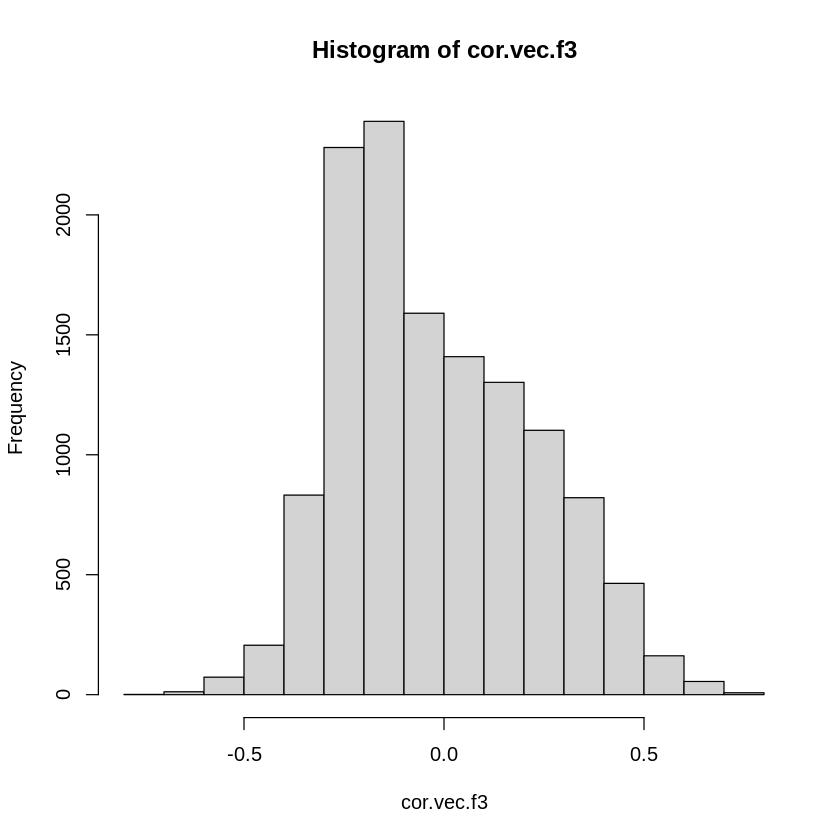

In [12]:
#Fold 3 Correlation Feature Selection
cor.vec.f3 <- apply (my.data3[,1:2000], 1, function (x){cor(x, aml.prognosis3[1:2000])})
hist (cor.vec.f3)
cor.ind.f3 <- c(which(cor.vec.f3 > 0.66), which(cor.vec.f3 < -0.59))
length(cor.ind.f3)
length(which(cor.vec.f3 > 0.66))
length(which(cor.vec.f3 < -0.59))

In [11]:
# #Fold 4
# my.data4 <- cbind(data.1[,-fold4.ind],data.1[,fold4.ind])
# my.info4 <- rbind(info.1[-fold4.ind,],info.1[fold4.ind,])
# aml.prognosis4 <- rep(0, length(my.info4$Disease))
# aml.prognosis4[which (my.info4$Disease == "AML")] <- 1
# #Fold 4 Ttest Feature Selection
# zero.ind.f4 <- which(aml.prognosis4[1:2000] == 0)
# one.ind.f4 <- which(aml.prognosis4[1:2000] == 1)
# ttest.vec.f4 <- apply (my.data4, 1, function (x){(t.test(x[one.ind.f4] , x[zero.ind.f4]))$p.value})
# gene.ind2.fold4 <- order (ttest.vec.f4)[1:100]

In [12]:
# #Fold 5
# my.data5 <- cbind(data.1[,-fold5.ind],data.1[,fold5.ind])
# my.info5 <- rbind(info.1[-fold5.ind,],info.1[fold5.ind,])
# aml.prognosis5 <- rep(0, length(my.info5$Disease))
# aml.prognosis5[which (my.info5$Disease == "AML")] <- 1
# #Fold 5 Ttest Feature Selection
# zero.ind.f5 <- which(aml.prognosis5[1:2000] == 0)
# one.ind.f5 <- which(aml.prognosis5[1:2000] == 1)
# ttest.vec.f5 <- apply (my.data5, 1, function (x){(t.test(x[one.ind.f5] , x[zero.ind.f5]))$p.value})
# gene.ind2.fold5 <- order (ttest.vec.f5)[1:100]

#### Ensemble method, majority count of 3 binary vectors

In [13]:
#Ensemble of 3, majority count for binary classification (0,1)
maj.count <- function(a,b,c){
  vec <- NULL
  for (i in 1:length(a)) {
    temp <- a[i] + b[i] + c[i]
    vote <- 0
    if(temp >= 2){
      vote <- 1
    }
    vec <- c(vec,vote)
  }
  return(vec)
}

### Ensemble A model 1   random forest random 50 genes from top 100
#### error rate on dataset 1 fold 1 test set: ~ 0.07

In [14]:
#random Forest fold1 50 of top 100 pvalue genes

ret.randForest.tt.f1 <- randomForest (x=t(my.data1[fold1.group1.50.tt,1:2000]), y= as.factor(aml.prognosis1[1:2000]))
pred.rf.50.tt <- predict(ret.randForest.tt.f1, t(my.data1[fold1.group1.50.tt,2001:2500]))
t1 <- table(pred.rf.50.tt, aml.prognosis1[2001:2500])
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1)
error_rate
length(pred.rf.50.tt)

#format predictions for use in ensemble method
pred.rf.50.tt <- as.numeric(as.character(pred.rf.50.tt))
pred.rf.50.tt[1:5]

[1] 0.068

[1] 500

[1] 1 0 0 1 0

In [15]:
#saveRDS(ret.randForest.tt.f1, file = 'model.rF.1.RData')

#### Ensemble A model 2, SVM linear, fold1 ttest 100 genes error rate 0.058

In [15]:
# predict fold1 test set
model.svm.lin <- svm(aml.prognosis1[1:2000] ~., data = t(my.data1[gene.ind2.fold1,1:2000]), kernel = "linear")
pred.svm.lin <- predict(model.svm.lin, t(my.data1[gene.ind2.fold1,2001:2500]))
pred.svm.lin <- as.numeric(round(pred.svm.lin))
pred.svm.lin[1:10]
t1 <- table(pred.svm.lin, aml.prognosis1[2001:2500])
t1
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1)
error_rate

[1] 1 0 0 1 0 0 1 0 0 0

            
pred.svm.lin   0   1
           0 273  15
           1  14 198

[1] 0.058

In [17]:
#this is fold1 svm radial on top 100 pvalue genes
#saveRDS(svm_model, file = 'model.svm.rad.1.RData')

#### Ensemble A model 3, SVM Radial, fold 1 ttest 100 genes error rate 0.022

In [16]:
model.svm.rad <- svm(aml.prognosis1[1:2000] ~., data = t(my.data1[gene.ind2.fold1,1:2000]), kernel = "radial")
pred.svm.rad <- predict(model.svm.rad, t(my.data1[gene.ind2.fold1,2001:2500]))
pred.svm.rad <- as.numeric(round(pred.svm.rad))
t1 <- table(pred.svm.rad, aml.prognosis1[2001:2500])
t1
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1)
error_rate

            
pred.svm.rad   0   1
           0 282   6
           1   5 207

[1] 0.022

In [19]:
#saveRDS(svm_model_linear, file = 'model.svm.lin.1.RData')

#### Ensemble A, trained on DS 1, tested DS 1, error rate ~ 0.03

In [17]:
ret.ensemble.a <- maj.count(pred.rf.50.tt, pred.svm.lin, pred.svm.rad)
t2 <- table(ret.ensemble.a, aml.prognosis1[2001:2500])
error_rate <- (sum(t2) - sum(diag(t2)))  /  sum(t2)
error_rate

[1] 0.026

### Ensemble B, 3 methods trained and tested within data set 1
### knn (100 genes), lasso (37 genes), random Forest (100 genes)
### ensemble B model 1, knn feature selected with ttest fold1 

In [18]:
# knn feature selected with ttest fold1 
library(class)
ret.knn.tt.f1 <- knn(train =t(my.data1[gene.ind2.fold1,1:2000]), test=t(my.data1[gene.ind2.fold1,2001:2500]),cl=aml.prognosis1[1:2000], k=5)
#gene.signature.knn <- row.names(my.data1[gene.ind2.fold1,])
ret.knn.tt.f1 <- as.numeric(as.character(ret.knn.tt.f1))
t1 <- table (ret.knn.tt.f1, aml.prognosis1[2001:2500])
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1) 
error_rate
t1

[1] 0.02

             
ret.knn.tt.f1   0   1
            0 283   6
            1   4 207

#### Ensemble B model 2, Lasso 37 genes correlation selected in fold1 

In [19]:
#feature-selected correlation 37genes fold1
library(glmnet)
model.lasso.1 <- cv.glmnet(t(my.data1[cor.ind2.f1 ,1:2000]),aml.prognosis1[1:2000] )
pred.lasso.cor <- predict(model.lasso.1, t(my.data1[cor.ind2.f1,2001:2500]))
pred.lasso.cor <- round(pred.lasso.cor)
t2 <- table(pred.lasso.cor, aml.prognosis1[2001:2500])
error_rate <- (sum(t2) - sum(diag(t2)))  /  sum(t2)
error_rate
t2

[1] 0.056

              
pred.lasso.cor   0   1
             0 274  15
             1  13 198

#### Ensemble B model 3, random forest feature selected ttest fold 1

In [20]:
#random Forest fold1 
library(randomForest)
ret.randForest.tt.f1 <- randomForest (x=t(my.data1[gene.ind2.fold1,1:2000]), y= as.factor(aml.prognosis1[1:2000]))
pred.rf <- predict(ret.randForest.tt.f1, t(my.data1[gene.ind2.fold1,2001:2500]))
t1 <- table(pred.rf, aml.prognosis1[2001:2500])
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1)
error_rate
t1

#format predictions for use in ensemble method
pred.rf <- as.numeric(as.character(pred.rf))

[1] 0.032

       
pred.rf   0   1
      0 280   9
      1   7 204

### Ensemble B error rate: 0.03

In [21]:
# results1 <- round(as.numeric(as.character(ret.knn.tt.f1)))
# results2 <- round(as.numeric(as.character(pred.lasso.cor)))
# results3 <- round(as.numeric(as.character(pred.rf)))
ret.ensemble <- maj.count(ret.knn.tt.f1, pred.lasso.cor, pred.rf)
length(ret.ensemble)
ret.knn.tt.f1[1:15]
pred.lasso.cor[1:15]
pred.rf[1:15]
ret.ensemble[1:15]

[1] 500

[1] 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0

[1] 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0

[1] 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0

[1] 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0

#### shown above, 3 model predictions and the result ensemble prediction: last row.
#### below, Ensemble B error rate 0.03

In [22]:
t2 <- table(ret.ensemble, aml.prognosis1[2001:2500])
error_rate <- (sum(t2) - sum(diag(t2)))  /  sum(t2)
error_rate

[1] 0.03

#### A few other models to compare

In [23]:
#non-feature-selected fold1

ret.lasso <- cv.glmnet(t(my.data1[ ,1:2000]),aml.prognosis1[1:2000] )
pred.lasso <- predict(ret.lasso, t(my.data1[,2001:2500]))
t2 <- table(round(pred.lasso), aml.prognosis1[2001:2500])
error_rate <- (sum(t2) - sum(diag(t2)))  /  sum(t2)
error_rate
t2

[1] 0.018

   
      0   1
  0 284   6
  1   3 207

In [41]:
#lasso
#feature-selected correlation fold3 33 genes
library(glmnet)
ret.lasso.cor <- cv.glmnet(t(my.data1[cor.ind.f3 ,1:2000]),aml.prognosis1[1:2000] )
pred.lasso.cor <- predict(ret.lasso.cor, t(my.data1[cor.ind.f3,2001:2500]))
t2 <- table(round(pred.lasso.cor), aml.prognosis1[2001:2500])
error_rate <- (sum(t2) - sum(diag(t2)))  /  sum(t2)
error_rate
t2

[1] 0.054

   
      0   1
  0 274  14
  1  13 199

### randomForest feature selected with ttest fold 2

In [42]:
#fold 2, 100 ttest genes
ret.randForest <- randomForest (x=t(my.data2[gene.ind2.fold2,1:2000]), y= as.factor(aml.prognosis2[1:2000]))
pred.rf <- predict(ret.randForest, t(my.data2[gene.ind2.fold2,2001:2500]))
t1 <- table(pred.rf, aml.prognosis2[2001:2500])
error_rate <- (sum(t1) - sum(diag(t1)))  /  sum(t1)
error_rate
t1

[1] 0.028

       
pred.rf   0   1
      0 299   3
      1  11 187

### Comparison of folds

In [43]:
# Commmon indexes in ttests from fold1 and fold2
ttfold1_and_ttfold2 <- intersect(gene.ind2.fold1,gene.ind2.fold2)
length(ttfold1_and_ttfold2)

[1] 93

In [44]:
# Commmon indexes in ttests from fold1 and fold3
ttfold1_and_ttfold3 <- intersect(gene.ind2.fold1,gene.ind2.fold3)
length(ttfold1_and_ttfold3)

[1] 92

In [45]:
# Commmon indexes in ttests from fold3 and fold2
ttfold3_and_ttfold2 <- intersect(gene.ind2.fold3,gene.ind2.fold2)
length(ttfold3_and_ttfold2)

[1] 92

In [46]:
#only 1 of the 33 genes selected by correlation fold 3 is not 'in' top 37 cor-selected genes of fold1
length(cor.ind.f3)
length(cor.ind2.f1)
length(intersect(cor.ind2.f1,cor.ind.f3))

[1] 32

In [47]:
#### AML proportion overall
aml.prognosis <- rep(0, length(info.1$Disease))
aml.prognosis[which (info.1$Disease == "AML")] <- 1
sum(aml.prognosis) / 2500

[1] 0.3944

In [48]:
#AML proportion in folds 1,2,3
sum(aml.prognosis1[1:2000])/2000
sum(aml.prognosis2[1:2000])/2000
sum(aml.prognosis3[1:2000])/2000

[1] 0.3865

[1] 0.398

[1] 0.3975

In [12]:
#top 37 pvalue genes
top37.ind.f1.tt <- order (ttest.vec.f1)[1:37]
top100.ind.f1.tt <- gene.ind2.fold1

#cor.ind2.f1 <- c(which(cor.vec.f1 > 0.65), which(cor.vec.f1 < -0.6)) # 37 genes
length(which(cor.vec.f1 > 0.65)) # 23 genes
length(which(cor.vec.f1 < -0.6)) # 14 genes

# find correlation indexes balanced + / - correlation, with length close to 100
length(which(cor.vec.f1 > 0.61)) # 47 genes
length(which(cor.vec.f1 < -0.53)) # 49 genes
top96.ind.cor.f1 <- c(which(cor.vec.f1 > 0.61), which(cor.vec.f1 < -0.53)) #96 genes

[1] 23

[1] 14

[1] 47

[1] 49

#### Feature Selection Correlation vs Ttest, common genes in top 37 and top 96 lists 
##### 30 / 37 genes intersect
##### 75 / 96 genes intersect

In [15]:
# how manu of top 37 genes intersect? cor vs ttest
length(intersect(top37.ind.f1.tt, cor.ind2.f1))

#intersection of top 96 genes cor vs ttest
length(intersect(top100.ind.f1.tt, top96.ind.cor.f1))

[1] 30

[1] 75